# Cálculo de la frecuencia cardiaca a partir del algoritmo statHRMAlgo 

Analizando la **SPO2 task** y la función statHRMAlgo(), veo que el método de cálculo de la frecuencia cardíaca se basa en:

- **Promedio móvil:** Se acumulan valores de la señal en una ventana deslizante (*movingWindowHP*).

- **Detección de picos:** Se buscan máximos y mínimos locales en un buffer de 20 muestras (*peakWindowHP*).

- **Cálculo de la frecuencia:** Se mide la distancia entre picos (*lastPeak*), y se usa la ecuación:

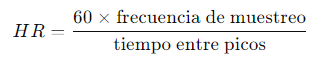

Se filtra entre 40 y 220 BPM.

- **Filtrado del resultado:** Se eliminan valores extremos y se toma un promedio.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def moving_average(signal, window_size=20):
    return np.convolve(signal, np.ones(window_size)/window_size, mode='valid')

def detect_peaks(signal, window_size=20):
    peaks, _ = find_peaks(signal, distance=window_size)
    return peaks

def detect_valleys(signal, window_size=20):
    valleys, _ = find_peaks(-signal, distance=window_size)
    return valleys

def calculate_heart_rate(peaks, sampling_rate=60):
    if len(peaks) < 2:
        return None  # No suficientes picos detectados
    
    rr_intervals = np.diff(peaks) / sampling_rate  # Intervalos RR en segundos
    heart_rates = 60 / rr_intervals  # FC en latidos por minuto
    
    # Filtrar valores fuera de un rango razonable
    heart_rates = heart_rates[(heart_rates > 40) & (heart_rates < 220)]
    
    if len(heart_rates) == 0:
        return None
    
    return np.median(heart_rates)

# Cargar datos
file_path = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\save_log2\raw_data_95_77_2.csv"
df = pd.read_csv(file_path, sep=';', decimal='.', engine='python')
time = df.iloc[:, 0].values  # Suponiendo que la primera columna es el tiempo
data_ir = df.iloc[:, 1].values  # Suponiendo que la segunda columna es la señal IR

# Aplicar media móvil
data_ir_smoothed = moving_average(data_ir)

# Detectar picos y valles
peaks = detect_peaks(data_ir_smoothed)
valleys = detect_valleys(data_ir_smoothed)

# Calcular frecuencia cardíaca
heart_rate = calculate_heart_rate(peaks)

print(f"Frecuencia cardíaca estimada: {heart_rate} BPM")



Frecuencia cardíaca estimada: 81.81818181818183 BPM


In [8]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks

def estimate_heart_rate(csv_file):
    # Cargar datos con separador ';'
    df = pd.read_csv(csv_file, sep=';')
    
    # Extraer el tiempo y la señal RED:
    time = df.iloc[:, 0].values  # selecciona la primera columna del DataFrame (que es el tiempo en milisegundos).
    red_signal = df.iloc[:, 3].values  # selecciona la cuarta columna del DataFrame (que es la señal RED, que contiene 
                                       # los valores de intensidad de la luz en el sensor)
    
    # Convertir tiempo a segundos
    
    # convertimos el tiempo de milisegundos a segundos restando el valor inicial de tiempo (para que empiece desde cero) y 
    # luego dividiendo entre 1000 para convertir milisegundos a segundos.
    time = (time - time[0]) / 1000.0
    
    # Aplicar media móvil para suavizar la señal
    
    # La señal RED puede tener ruido, por lo que utilizamos un filtro de media móvil para suavizarla.
    # np.convolve(red_signal, np.ones(window_size)/window_size, mode='valid') aplica una convolución de la señal con una ventana 
    # de tamaño window_size (en este caso, 10). Esto suaviza la señal tomando el promedio de los valores en esa ventana.
    window_size = 10
    red_signal_smooth = np.convolve(red_signal, np.ones(window_size)/window_size, mode='valid')
    
    # Detección de picos (máximos)
    
    # find_peaks() es una función que detecta los picos locales (máximos) en la señal.

    # distance=30 asegura que los picos estén separados al menos 30 muestras entre sí, evitando detecciones erróneas de picos
    # muy cercanos 
    # prominence=500 garantiza que solo se detecten picos que tengan una prominencia significativa, es decir, picos que 
    # sobresalgan lo suficiente del resto de la señal.
    peaks, _ = find_peaks(red_signal_smooth, distance=30, prominence=500)
    
    # Calcular intervalos entre picos
    
    # np.diff(time[peaks]) calcula las diferencias de tiempo entre los picos detectados. Estos valores son los intervalos RR, 
    # que corresponden al tiempo entre latidos del corazón (en segundos).
    peak_intervals = np.diff(time[peaks])
    
    # Calcular la frecuencia cardíaca (BPM)
    
    if len(peak_intervals) > 1:
        # Si se detectaron al menos dos picos, calculamos el intervalo medio entre los picos
        avg_rr_interval = np.mean(peak_intervals)  # Intervalo medio entre picos en segundos
        # La frecuencia cardíaca se calcula como 60 / avg_rr_interval, porque la frecuencia cardíaca es la cantidad de latidos 
        # por minuto (BPM), y el intervalo se mide en segundos. Por lo tanto, dividimos 60 segundos por el promedio de los intervalos.
        heart_rate = 60 / avg_rr_interval  # BPM
    else:
        # Si no se detectan suficientes picos, se retorna None
        heart_rate = None  # No se detectaron suficientes picos
    
    return heart_rate

# Ejecutar la estimación
csv_file = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\save_log2\raw_data_95_77_2.csv"
heart_rate = estimate_heart_rate(csv_file)


if heart_rate:
    # Si se pudo calcular la frecuencia cardíaca, se imprime el resultado con dos decimales
    print(f"Frecuencia cardíaca estimada: {heart_rate:.2f} BPM")
else:
    # Si no se detectaron suficientes picos, se imprime un mensaje indicando que no fue posible calcularla.
    print("No se detectaron suficientes picos para calcular la frecuencia cardíaca.")


Frecuencia cardíaca estimada: 74.49 BPM


In [29]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks

def estimate_heart_rate(csv_file):
    # Cargar datos con separador ';'
    df = pd.read_csv(csv_file, sep=';')
    time = df.iloc[:, 0].values  # Tiempo en ms
    red_signal = df.iloc[:, 3].values  # Señal RED
    
    # Convertir tiempo a segundos
    time = (time - time[0]) / 1000.0
    
    # Aplicar media móvil para suavizar la señal
    window_size = 5  # Reducido para mayor precisión
    red_signal_smooth = np.convolve(red_signal, np.ones(window_size)/window_size, mode='valid')
    
    # Detección de picos (máximos)
    peaks, _ = find_peaks(red_signal_smooth, distance=34, prominence=300)  # Ajustado para mejor detección
    
    # Calcular intervalos entre picos
    peak_intervals = np.diff(time[peaks])
    
    if len(peak_intervals) > 1:
        avg_rr_interval = np.mean(peak_intervals)  # Intervalo medio entre picos en segundos
        heart_rate = 60 / avg_rr_interval  # BPM
    else:
        heart_rate = None  # No se detectaron suficientes picos
    
    return heart_rate

# Ejecutar la estimación
csv_file = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\save_log2\raw_data_95_77_2.csv"
heart_rate = estimate_heart_rate(csv_file)

if heart_rate:
    print(f"Frecuencia cardíaca estimada: {heart_rate:.2f} BPM")
else:
    print("No se detectaron suficientes picos para calcular la frecuencia cardíaca.")


Frecuencia cardíaca estimada: 76.60 BPM


raw_data_91_91.csv → No se detectaron suficientes picos para calcular la frecuencia cardíaca.
raw_data_92_76.csv → Frecuencia cardíaca estimada: 84.35 BPM
raw_data_93_100.csv → No se detectaron suficientes picos para calcular la frecuencia cardíaca.
raw_data_95_77_2.csv → Frecuencia cardíaca estimada: 76.60 BPM
raw_data_95_80.csv → Frecuencia cardíaca estimada: 75.69 BPM
raw_data_95_81_papa.csv → Frecuencia cardíaca estimada: 80.14 BPM
raw_data_95_99.csv → Frecuencia cardíaca estimada: 95.18 BPM
raw_data_96_106.csv → Frecuencia cardíaca estimada: 23.32 BPM
raw_data_96_69.csv → Frecuencia cardíaca estimada: 71.56 BPM
raw_data_97_119.csv → Frecuencia cardíaca estimada: 31.84 BPM
raw_data_97_95.csv → Frecuencia cardíaca estimada: 92.76 BPM
raw_data_98_81.csv → Frecuencia cardíaca estimada: 80.50 BPM
raw_data_98_86.csv → Frecuencia cardíaca estimada: 84.81 BPM
raw_data_98_91.csv → Frecuencia cardíaca estimada: 26.20 BPM
raw_data_99_75.csv → No se detectaron suficientes picos para calcular 

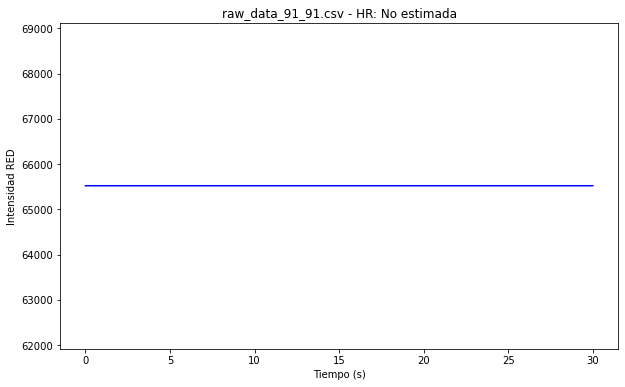

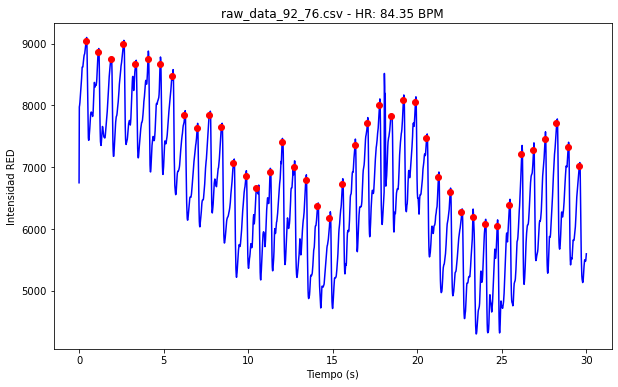

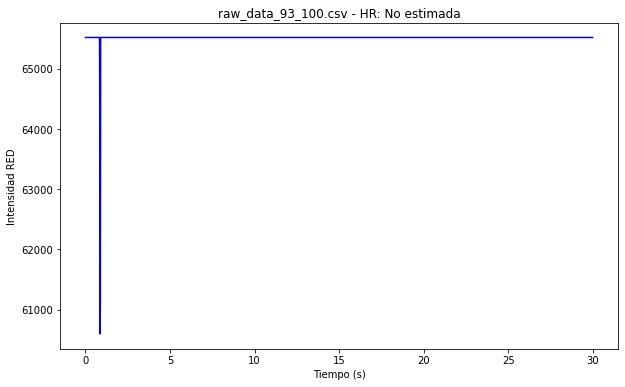

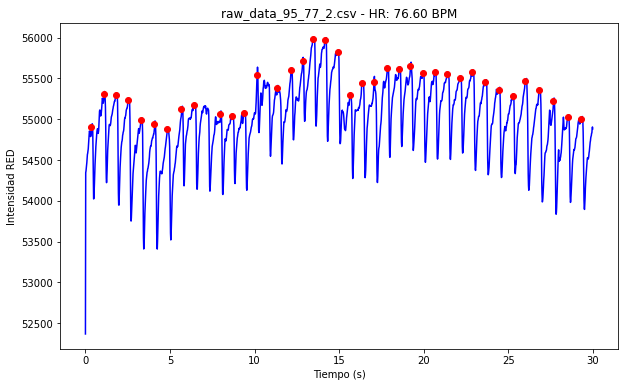

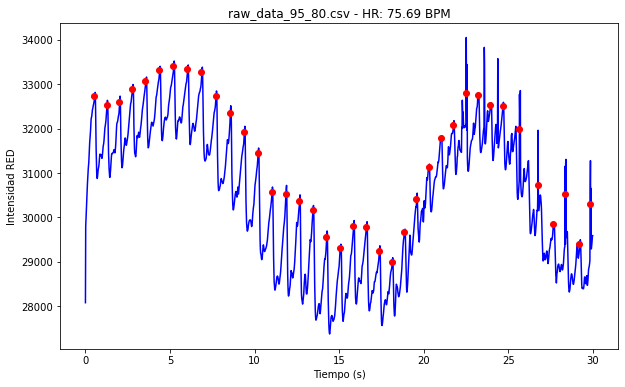

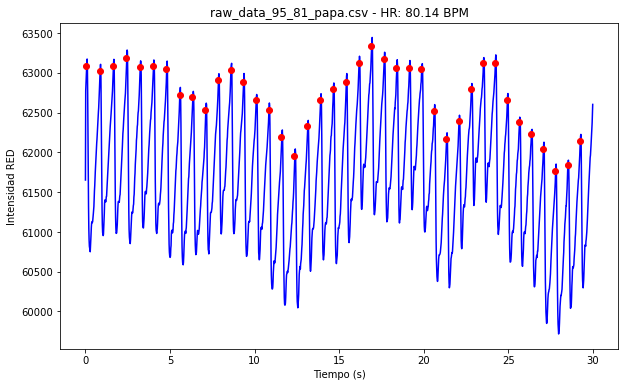

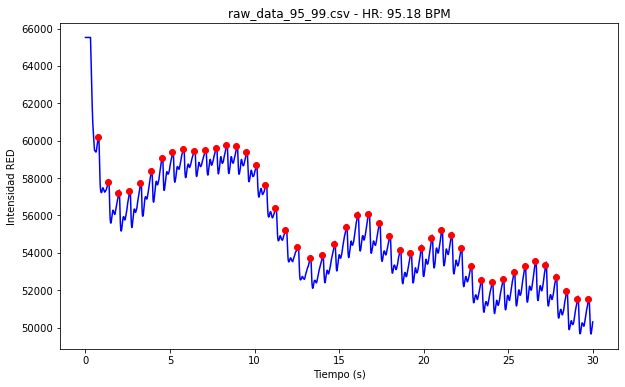

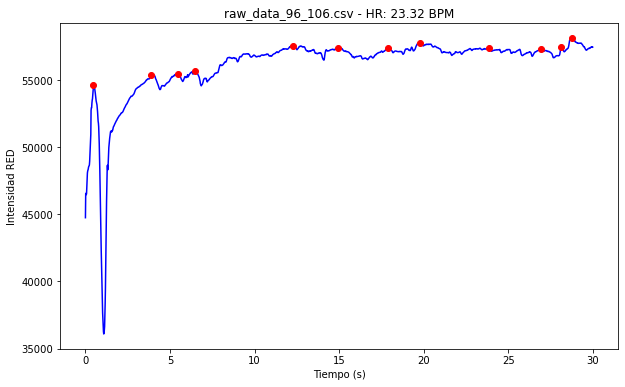

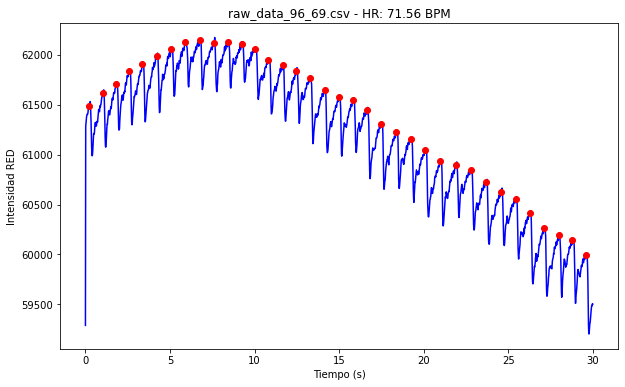

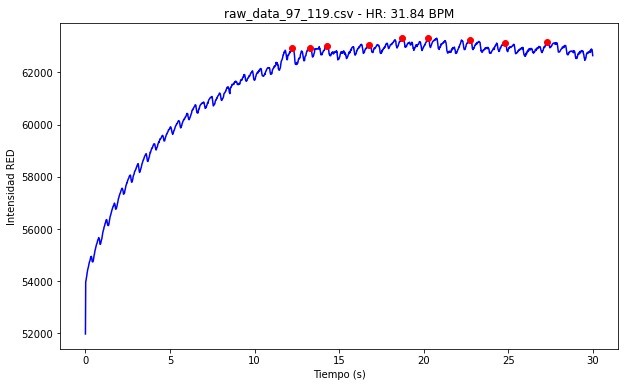

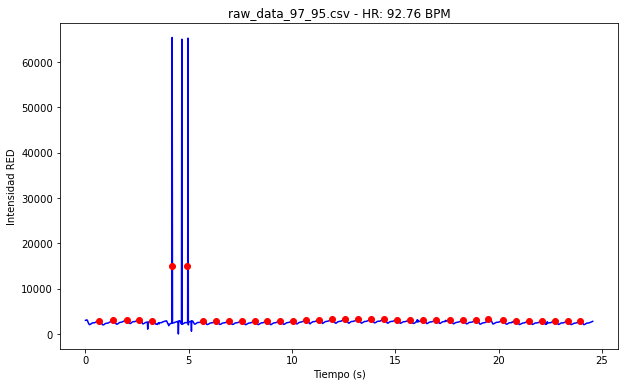

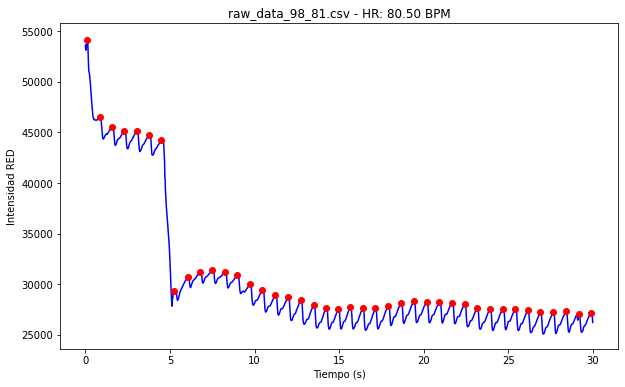

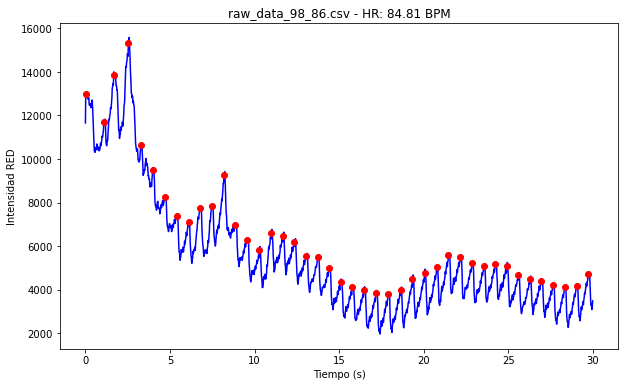

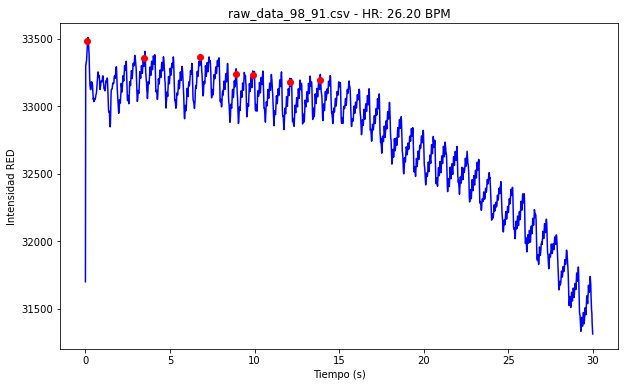

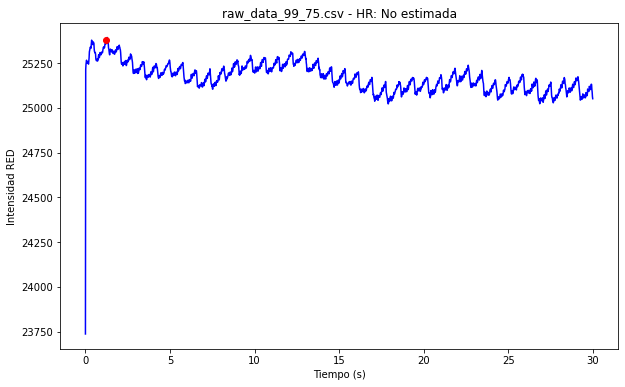

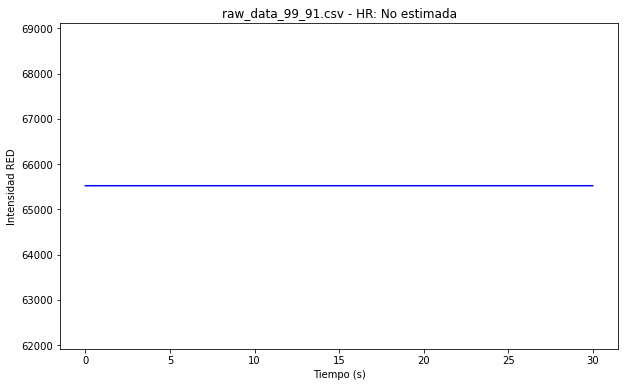

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def estimate_heart_rate(csv_file):
    # Cargar datos con separador ';'
    df = pd.read_csv(csv_file, sep=';')
    time = df.iloc[:, 0].values  # Tiempo en ms
    red_signal = df.iloc[:, 3].values  # Señal RED
    
    # Convertir tiempo a segundos
    time = (time - time[0]) / 1000.0
    
    # Aplicar media móvil para suavizar la señal
    window_size = 5  # Reducido para mayor precisión
    red_signal_smooth = np.convolve(red_signal, np.ones(window_size)/window_size, mode='valid')
    
    # Detección de picos (máximos)
    peaks, _ = find_peaks(red_signal_smooth, distance=34, prominence=300)  # Ajustado para mejor detección
    
    # Calcular intervalos entre picos
    peak_intervals = np.diff(time[peaks])
    
    if len(peak_intervals) > 1:
        avg_rr_interval = np.mean(peak_intervals)  # Intervalo medio entre picos en segundos
        heart_rate = 60 / avg_rr_interval  # BPM
    else:
        heart_rate = None  # No se detectaron suficientes picos
    
    return heart_rate, time, red_signal, red_signal_smooth, peaks

# Ruta de la carpeta con los archivos CSV
ruta_carpeta = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\save_log2"

# Recorrer todos los archivos CSV en la carpeta
for archivo in os.listdir(ruta_carpeta):
    if archivo.endswith(".csv"):
        ruta_archivo = os.path.join(ruta_carpeta, archivo)

        # Estimar la frecuencia cardíaca y obtener los datos necesarios
        heart_rate, time, red_signal, red_signal_smooth, peaks = estimate_heart_rate(ruta_archivo)

        # Imprimir el nombre del archivo y la HR estimada
        if heart_rate:
            print(f"{archivo} → Frecuencia cardíaca estimada: {heart_rate:.2f} BPM")
        else:
            print(f"{archivo} → No se detectaron suficientes picos para calcular la frecuencia cardíaca.")

        # Graficar la señal con los picos detectados
        plt.figure(figsize=(10, 6))
        plt.plot(time, red_signal, label="Señal RED", color="blue")
        plt.plot(time[peaks], red_signal_smooth[peaks], "ro", label="Picos detectados")
        plt.xlabel("Tiempo (s)")
        plt.ylabel("Intensidad RED")
        plt.title(f"{archivo} - HR: {heart_rate:.2f} BPM" if heart_rate else f"{archivo} - HR: No estimada")


El parámetro que he cambiado es distance, cuanto más aumenta el numero, más picos detecta, y cuanto menos aumenta, menos detecta